In [ ]:
import os
import time

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW, Adam


In [ ]:
class Config:
    csv_path = ''
    seed = 2021
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

def seed_everything(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

config = Config()
seed_everything(config.seed)

In [ ]:
df_ptbdb = pd.read_csv('/Users/adityadwivedi/Downloads/ECG/ptbdb_abnormal.csv')
df_mitbih = pd.read_csv('/Users/adityadwivedi/Downloads/ECG/mitbih_train.csv')
df_ptbdb.head()

,9.322328567504882812e-01,8.696785569190979004e-01,8.861859440803527832e-01,9.296264052391052246e-01,9.087749719619750977e-01,9.339704513549804688e-01,8.010425567626953125e-01,7.497828006744384766e-01,6.872285008430480957e-01,6.350998878479003906e-01,...,0.000000000000000000e+00.117,0.000000000000000000e+00.118,0.000000000000000000e+00.119,0.000000000000000000e+00.120,0.000000000000000000e+00.121,0.000000000000000000e+00.122,0.000000000000000000e+00.123,0.000000000000000000e+00.124,0.000000000000000000e+00.125,1.000000000000000000e+00.1
0,1.000000,0.606941,0.384181,0.254237,0.223567,0.276836,0.253430,0.184826,0.153349,0.121872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.951613,0.923963,0.853303,0.791859,0.734255,0.672043,0.685100,0.670507,0.667435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.977819,0.899261,0.230129,0.032348,0.142329,0.223660,0.328096,0.367837,0.381701,0.389094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.935618,0.801661,0.805815,1.000000,0.722741,0.480789,0.454829,0.319834,0.266874,0.308411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.925265,0.433352,0.073620,0.079197,0.136643,0.182934,0.182934,0.182376,0.196877,0.203569,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
df_mitbih_train = pd.read_csv('/Users/adityadwivedi/Downloads/ECG/mitbih_train.csv', header=None)
df_mitbih_test = pd.read_csv( '/Users/adityadwivedi/Downloads/ECG/mitbih_test.csv', header=None)
df_mitbih = pd.concat([df_mitbih_train, df_mitbih_test], axis=0)
df_mitbih.rename(columns={187: 'class'}, inplace=True)

id_to_label = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}
df_mitbih['label'] = df_mitbih.iloc[:, -1].map(id_to_label)
print(df_mitbih.info())

<class 'pandas.core.frame.DataFrame'>
Index: 109446 entries, 0 to 21891
Columns: 189 entries, 0 to label
dtypes: float64(188), object(1)
memory usage: 158.7+ MB
None


In [ ]:
df_mitbih.to_csv('data.csv', index=False)
config.csv_path = 'data.csv'

In [ ]:
df_mitbih['label'].value_counts()

label
Normal                               90589
Fusion of paced and normal            8039
Premature ventricular contraction     7236
Artial Premature                      2779
Fusion of ventricular and normal       803
Name: count, dtype: int64

/var/folders/7d/vzx818195gndjk3505n2d51h0000gn/T/ipykernel_20868/4048187147.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
/var/folders/7d/vzx818195gndjk3505n2d51h0000gn/T/ipykernel_20868/4048187147.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=15);


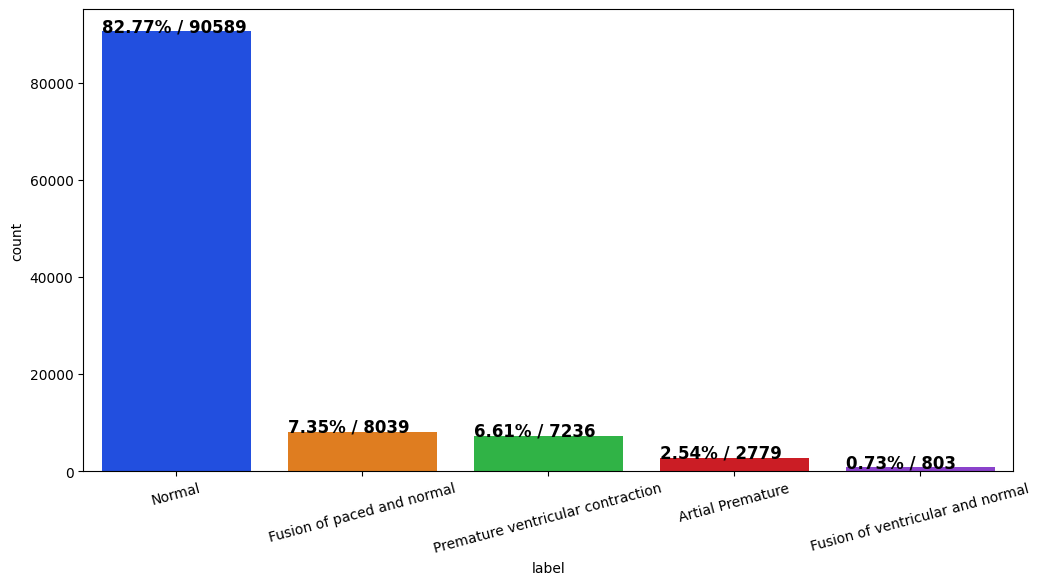

In [ ]:
percentages = [count / df_mitbih.shape[0] * 100 for count in df_mitbih['label'].value_counts()]

fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(
    x=df_mitbih['label'],
    ax=ax,
    palette="bright",
    order=df_mitbih['label'].value_counts().index
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=15);

for percentage, count, p in zip(
    percentages,
    df_mitbih['label'].value_counts(sort=True).values,
    ax.patches):

    percentage = f'{np.round(percentage, 2)}%'
    x = p.get_x() + p.get_width() / 2 - 0.4
    y = p.get_y() + p.get_height()
    ax.annotate(str(percentage)+" / "+str(count), (x, y), fontsize=12, fontweight='bold')

plt.savefig('data_dist.png', facecolor='w', edgecolor='w', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.savefig('data_dist.svg', facecolor='w', edgecolor='w', format='svg',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

In [ ]:
class ECGDataset(Dataset):

    def __init__(self, df):
        self.df = df
        self.data_columns = self.df.columns[:-2].tolist()

    def __getitem__(self, idx):
        signal = self.df.loc[idx, self.data_columns].astype('float32')
        signal = torch.FloatTensor([signal.values])
        target = torch.LongTensor(np.array(self.df.loc[idx, 'class']))
        return signal, target

    def __len__(self):
        return len(self.df)

def get_dataloader(label_name, batch_size):
    df = pd.read_csv(config.csv_path)
    df = df.loc[df['label'] == label_name]
    df.reset_index(drop=True, inplace=True)
    dataset = ECGDataset(df)
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=0)
    return dataloader


dataloader = get_dataloader(label_name='Artial Premature', batch_size=96)

print(len(dataloader))
x,y = next(iter(dataloader))
x.shape, y.shape

29


/var/folders/7d/vzx818195gndjk3505n2d51h0000gn/T/ipykernel_20868/3944258185.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  signal = torch.FloatTensor([signal.values])


(torch.Size([96, 1, 187]), torch.Size([96]))

Epoch 0/3000 - VAE Loss: 840.6017150878906 - D Loss: 1.315661072731018 - G Loss: 231.95309448242188


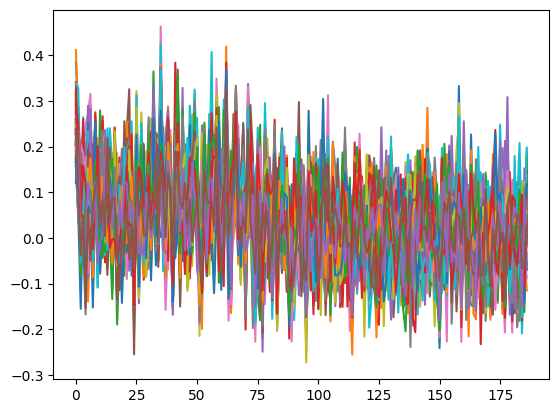

Epoch 500/3000 - VAE Loss: 220.7388178507487 - D Loss: 4.255487147020176e-05 - G Loss: 67.84859466552734


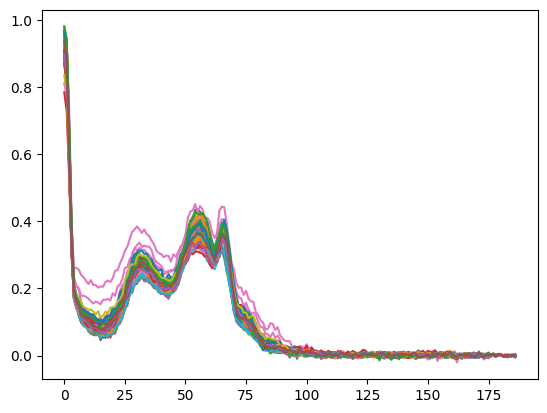

Epoch 1000/3000 - VAE Loss: 208.60837639702692 - D Loss: 4.845035437028855e-05 - G Loss: 65.80232238769531


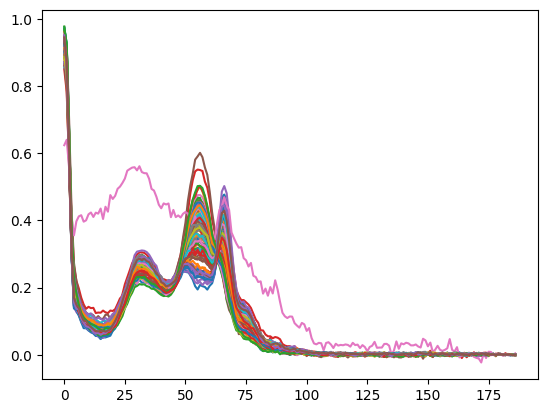

Epoch 1500/3000 - VAE Loss: 217.719361199273 - D Loss: 2.9178731892898213e-06 - G Loss: 74.96587371826172


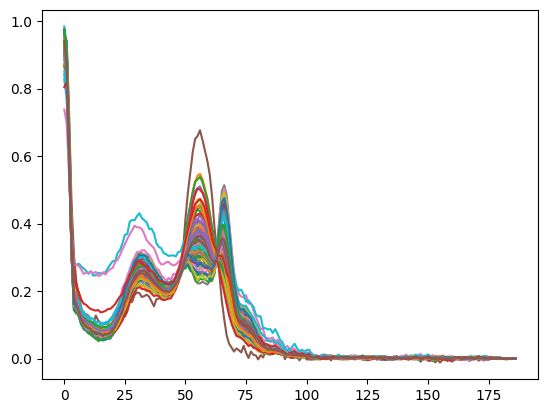

Epoch 2000/3000 - VAE Loss: 213.97359975179037 - D Loss: 1.139297728514066e-05 - G Loss: 69.08380889892578


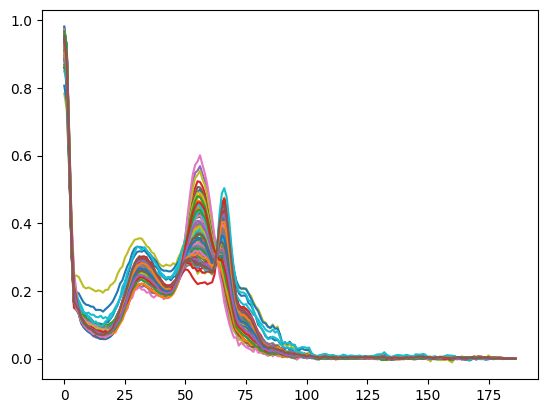

Epoch 2500/3000 - VAE Loss: 202.3473663330078 - D Loss: 0.0017742429627105594 - G Loss: 74.62147521972656


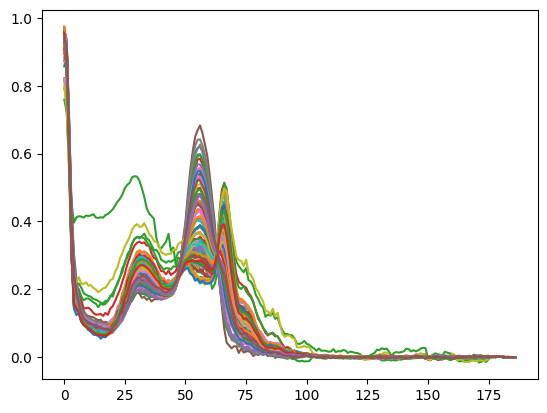

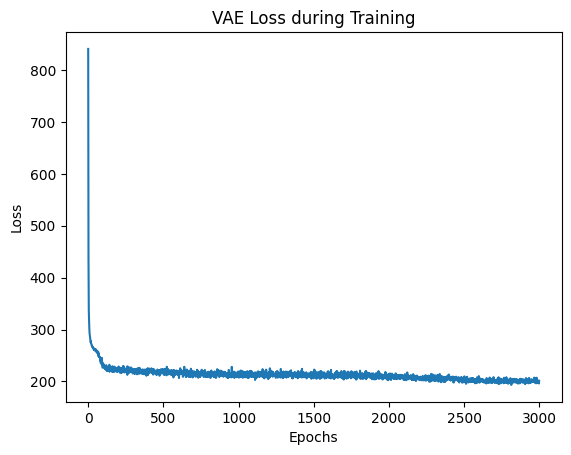

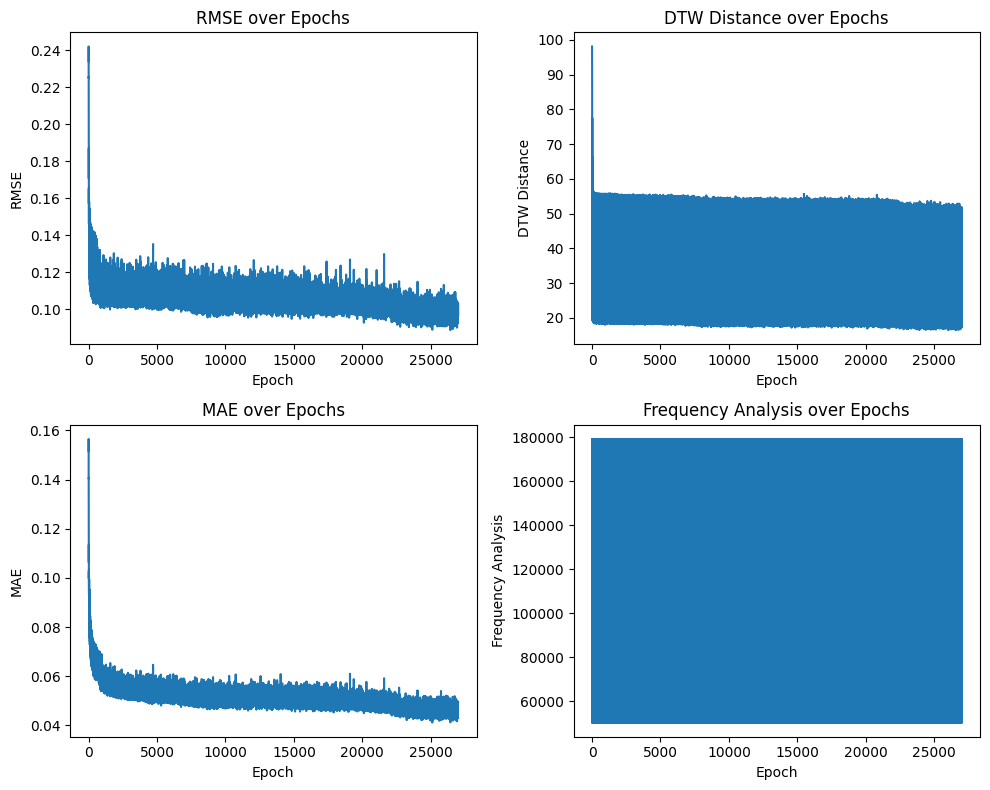

Final Metrics:
Final Rmse: 0.10269517451524734
Final Dtw: 17.440391526091844
Final Mae: 0.04964553564786911
Final Frequency: 50402.15625


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from fastdtw import fastdtw


# VAE Encoder Class
class Encoder(nn.Module):
    def __init__(self, latent_dim=100):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(187, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3_mu = nn.Linear(256, latent_dim)
        self.fc3_logvar = nn.Linear(256, latent_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mu = self.fc3_mu(x)
        logvar = self.fc3_logvar(x)
        return mu, logvar


# VAE Decoder (Generator for DCGAN)
class Decoder(nn.Module):
    def __init__(self, latent_dim=100):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 187)

    def forward(self, z):
        z = F.relu(self.fc1(z))
        z = F.relu(self.fc2(z))
        z = torch.tanh(self.fc3(z))  # Normalize output for ECG signal
        return z


# Reparameterization Trick
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std


# VAE Class (Combining Encoder and Decoder)
class VAE(nn.Module):
    def __init__(self, latent_dim=100):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = reparameterize(mu, logvar)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, mu, logvar

    def loss_function(self, reconstructed_x, x, mu, logvar):
        # Reconstruction loss (MSE)
        BCE = F.mse_loss(reconstructed_x, x, reduction='sum')

        # KL divergence
        KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return BCE + KL


# DCGAN Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(187, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.fc3(x)
        return x  # No sigmoid here; BCEWithLogitsLoss applies it


# VAE Trainer Class
class VAETrainer:
    def __init__(self, model, discriminator, batch_size, num_epochs, label, lr=0.0002):
        self.device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
        self.model = model.to(self.device)
        self.discriminator = discriminator.to(self.device)
        self.g_optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.d_optimizer = optim.Adam(self.discriminator.parameters(), lr=lr)
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.dataloader = get_dataloader(label_name=label, batch_size=self.batch_size)
        self.d_loss_fn = nn.BCEWithLogitsLoss()

        self.losses = []
        self.eval_metrics = {
            'rmse': [],
            'dtw': [],
            'mae': [],
            'frequency': [],
        }

    def _calculate_metrics(self, real_data, fake_data):
        # Detach tensors from the computation graph before converting to NumPy
        real_data = real_data.detach().cpu().numpy()
        fake_data = fake_data.detach().cpu().numpy()

        # RMSE
        rmse = np.sqrt(((real_data - fake_data) ** 2).mean())
        self.eval_metrics['rmse'].append(rmse)

        # DTW Distance
        dtw_distance, _ = fastdtw(real_data, fake_data)
        self.eval_metrics['dtw'].append(dtw_distance)

        # MAE
        mae = np.abs(real_data - fake_data).mean()
        self.eval_metrics['mae'].append(mae)

        # Frequency Analysis (example: power spectral density)
        frequency = np.sum(np.abs(np.fft.fft(real_data)) ** 2)
        self.eval_metrics['frequency'].append(frequency)

    def _one_epoch(self):
        epoch_loss = 0
        for i, data in enumerate(self.dataloader, 0):
            real_data = data[0].to(self.device)
            batch_size = real_data.size(0)
            real_labels = torch.ones(batch_size, 1).to(self.device)
            fake_labels = torch.zeros(batch_size, 1).to(self.device)

            # Train Discriminator with real data
            self.discriminator.zero_grad()
            real_output = self.discriminator(real_data).view(-1)
            d_loss_real = self.d_loss_fn(real_output, real_labels.view(-1))

            # Train Discriminator with fake data
            z = torch.randn(batch_size, 100, device=self.device)
            fake_data = self.model.decoder(z)
            fake_output = self.discriminator(fake_data).view(-1)
            d_loss_fake = self.d_loss_fn(fake_output, fake_labels.view(-1))

            # Total Discriminator loss
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            self.d_optimizer.step()

            # Train VAE (Generator)
            self.model.zero_grad()
            reconstructed_data, mu, logvar = self.model(real_data)
            g_loss = self.model.loss_function(reconstructed_data, real_data, mu, logvar)
            g_loss.backward()
            self.g_optimizer.step()

            # Calculate evaluation metrics
            self._calculate_metrics(real_data, reconstructed_data)

            epoch_loss += g_loss.item()

        return epoch_loss / len(self.dataloader), d_loss.item(), g_loss.item()

    def run(self):
        for epoch in range(self.num_epochs):
            epoch_loss, d_loss, g_loss = self._one_epoch()
            self.losses.append(epoch_loss)

            if epoch % 500 == 0:
                print(f"Epoch {epoch}/{self.num_epochs} - VAE Loss: {epoch_loss} - D Loss: {d_loss} - G Loss: {g_loss}")

                # Visualize fake ECG signals
                with torch.no_grad():
                    z = torch.randn(self.batch_size, 100, device=self.device)
                    fake_ecg = self.model.decoder(z).cpu().numpy()
                    plt.plot(fake_ecg.transpose())
                    plt.show()

        # Plot loss
        plt.plot(self.losses)
        plt.title("VAE Loss during Training")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.show()

        self._plot_metrics()
        self._print_final_metrics()

    def _plot_metrics(self):
        epochs = range(len(self.eval_metrics['rmse']))
        plt.figure(figsize=(10, 8))

        plt.subplot(2, 2, 1)
        plt.plot(epochs, self.eval_metrics['rmse'], label='RMSE')
        plt.title('RMSE over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('RMSE')

        plt.subplot(2, 2, 2)
        plt.plot(epochs, self.eval_metrics['dtw'], label='DTW Distance')
        plt.title('DTW Distance over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('DTW Distance')

        plt.subplot(2, 2, 3)
        plt.plot(epochs, self.eval_metrics['mae'], label='MAE')
        plt.title('MAE over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('MAE')

        plt.subplot(2, 2, 4)
        plt.plot(epochs, self.eval_metrics['frequency'], label='Frequency Analysis')
        plt.title('Frequency Analysis over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Frequency Analysis')

        plt.tight_layout()
        plt.show()

    def _print_final_metrics(self):
        print("Final Metrics:")
        for metric, values in self.eval_metrics.items():
            print(f"Final {metric.capitalize()}: {values[-1]}")


# Create and train VAE with DCGAN
vae = VAE(latent_dim=100)
discriminator = Discriminator()
trainer = VAETrainer(model=vae, discriminator=discriminator, batch_size=96, num_epochs=3000, label='Fusion of ventricular and normal')
trainer.run()


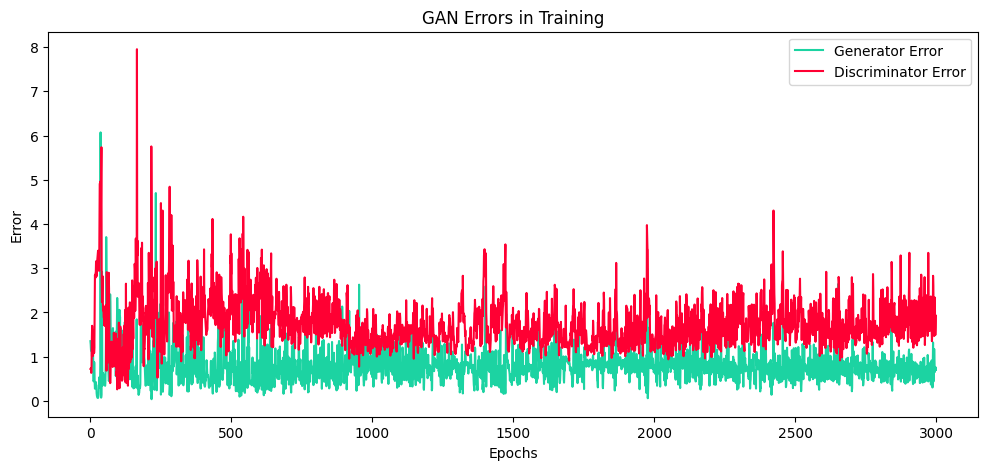

In [ ]:
plt.figure(figsize=(12, 5))
plt.title("GAN Errors in Training")
plt.plot(trainer.d_errors, label='Generator Error', c='#1CD3A2')
plt.plot(trainer.g_errors, label='Discriminator Error', c='#FF0033')
plt.xlabel("Epochs")
plt.ylabel('Error')
_ = plt.legend()
plt.savefig('Gan_Losses.png', facecolor='w', edgecolor='w', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.savefig('Gan_Losses.svg', facecolor='w', edgecolor='w', format='svg',
        transparent=False, bbox_inches='tight', pad_inches=0.1)